#Import and Load

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 4.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
import zipfile
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import spacy
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/Project/DL Excercise/data.csv.zip', 'r') as zip_ref:
  zip_ref.extractall('/content')

In [ ]:
df = pd.read_csv('/content/data.csv', encoding='unicode_escape')

#Cleaning

In [ ]:
#check stock code that only contains letter
dif_code = df[df['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
dif_code

array(['POST', 'D', 'C2', 'DOT', 'M', 'BANK CHARGES', 'S', 'AMAZONFEE',
       'DCGS0076', 'DCGS0003', 'gift_0001_40', 'DCGS0070', 'm',
       'gift_0001_50', 'gift_0001_30', 'gift_0001_20', 'DCGS0055',
       'DCGS0072', 'DCGS0074', 'DCGS0069', 'DCGS0057', 'DCGSSBOY',
       'DCGSSGIRL', 'gift_0001_10', 'PADS', 'DCGS0004', 'DCGS0073',
       'DCGS0071', 'DCGS0068', 'DCGS0067', 'DCGS0066P', 'B', 'CRUK'],
      dtype=object)

In [ ]:
df = df.dropna()

#list of peculiar stock code
not_product = df[df.StockCode.isin(dif_code)]["Description"].unique()
#filtering to just real product
list_product = df[~df["Description"].isin(not_product)]["Description"].unique()

#Word Count

In [ ]:
word_list = [i.split() for i in list_product]
word_list = [xs.lower() for x in word_list for xs in x]

In [ ]:
word_count = pd.DataFrame({"word":word_list, "count":1})
word_count = word_count.groupby("word").sum().reset_index()
word_count

word  count
0            "a"      1
1            "b"      1
2            "c"      1
3            "d"      1
4            "e"      1
...          ...    ...
2228      you're      1
2229        your     11
2230    yuletide      2
2231        zinc     49
2232  zinc/glass      1

[2233 rows x 2 columns]

In [ ]:
wlist = list(word_count[word_count['count'] >= 2]['word'])

##POS Analysis

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
df_p = []

for word in wlist:
  doc = nlp(word)
  for token in doc:
    df_p.append((token,token.pos_,spacy.explain(token.pos_)))

In [ ]:
df_p = pd.DataFrame(df_p)
df_p.columns = ['word', 'pos', 'explain']
df_p['word'] = df_p.word.astype(str)

#Sentence Embedding

In [ ]:
x = df_p[df_p.pos.isin(['NOUN','PROPN'])] #taking only noun and proper nouns

In [ ]:
model = SentenceTransformer(r"sentence-transformers/all-MiniLM-L12-v2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
#encoding all the word from list of product into 384 dimension Vector
def encode(data):
  embed = model.encode(data)
  embed_df = pd.merge(pd.DataFrame({"product":data}),pd.DataFrame(embed),left_index=True, right_index=True)
  return embed, embed_df

In [ ]:
wordstop0 = df_p[~df_p.pos.isin(['NOUN','PROPN'])]
wordstop0 = wordstop0['word']
wordstop0 = list(wordstop0)

wordstop1 = ['SET','PACK','BOX','BAG','T','VINTAGE','PINK','GREEN','BLUE','BLUES','WHITE','BLACK','HEART','CHRISTMAS','VINTAGE','RED','HALLOWEEN','OF','SMALL','MEDIUM','LARGE','missing','lost','LOVE','RETROSPOT','DESIGN','DECORATION']
wordstop1 = [x.lower() for x in wordstop1]
wordstop = [wordstop0, wordstop1]

wordstop = [xs for x in wordstop for xs in x]

In [ ]:
#eliminate word to just get the noun from description

lp = []
for sentence in list_product:
  if sentence.islower() == False or sentence.title() != sentence:
    update_word = " ".join([x for x in sentence.lower().split() if x not in wordstop0])
    lp.append(update_word)

In [ ]:
embed_s, embed_df_s = encode(lp) #encoding

#Clustering

In [ ]:
def km_clustering(data, iter=10):
  inertia =[]
  silhouette = []
  for i in range(2,iter):
    cluster = KMeans(n_clusters=i)
    cluster_labels = cluster.fit_predict(data)
    inertia.append(cluster.inertia_)
    silhouette.append(silhouette_score(data, cluster_labels))

  fig1 = px.line(x=[i for i in range(2,iter)],
               y=inertia,
               markers=True)
  fig2 = px.bar(x=[i for i in range(2,iter)],
                y=silhouette)
  fig1.show()
  fig2.show()

In [ ]:
#clustering from word vector
km_clustering(embed_s, 20)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

In [ ]:
clustering0 = KMeans(n_clusters=11)
clustering0.fit_predict(embed_s)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



array([10,  9,  1, ...,  2, 10,  0], dtype=int32)

In [ ]:
embed_df_s

product         0         1         2         3  \
0               heart t-light holder -0.074102  0.080908 -0.063111  0.050235   
1                              metal -0.074427  0.102548  0.043450  0.035012   
2     cream cupid hearts coat hanger -0.047700  0.054949 -0.000977  0.006106   
3                   union flag water -0.026437  0.051348  0.015758  0.033965   
4                  red hottie heart. -0.040192 -0.012948 -0.049545 -0.079622   
...                              ...       ...       ...       ...       ...   
3883                 letter "w" ring -0.041136  0.066385 -0.108220  0.007475   
3884                 letter "z" ring -0.014920  0.061616 -0.117847  0.057816   
3885       crystal skull phone charm -0.126766  0.116104  0.005084 -0.111355   
3886      cream heart t-light holder -0.058556  0.047750 -0.036045  0.037477   
3887              paper craft birdie -0.001599  0.117828 -0.042222  0.033749   

             4         5         6         7         8  ...       374  \
0    -0.016639 -0.127495  0.110421  0.065967  0.027037  ...  0.004221   
1    -0.048313 -0.077468  0.148477  0.019021 -0.037543  ...  0.014412   
2     0.022035  0.015823  0.081434  0.004983 -0.049473  ... -0.037112   
3     0.008084 -0.008122  0.078717 -0.001963 -0.035246  ...  0.007904   
4     0.046238 -0.026383  0.141327 -0.015483  0.029542  ... -0.074134   
...        ...       ...       ...       ...       ...  ...       ...   
3883 -0.019483  0.017894  0.038507  0.090369  0.031972  ... -0.086416   
3884 -0.066491  0.025504  0.098870  0.009171 -0.020401  ...  0.011272   
3885 -0.081878 -0.061952  0.059832  0.057613  0.039104  ... -0.019490   
3886 -0.001470 -0.104447  0.125742  0.066410 -0.014500  ...  0.013354   
3887 -0.024315  0.002027 -0.002934 -0.019275 -0.042407  ... -0.040870   

           375       376       377       378       379       380       381  \
0    -0.023983  0.037637  0.015955 -0.099140 -0.063555 -0.009863 -0.020367   
1     0.020474  0.019083  0.059461 -0.036027 -0.036786  0.030173 -0.015544   
2    -0.071592 -0.013727 -0.031149  0.007650  0.019635 -0.094777 -0.091979   
3    -0.011599 -0.084691 -0.040646  0.003888 -0.069435  0.015138  0.020889   
4    -0.079996 -0.042794  0.001833 -0.036648 -0.016758  0.048801 -0.034644   
...        ...       ...       ...       ...       ...       ...       ...   
3883 -0.014834 -0.030532 -0.031772 -0.005350 -0.032126 -0.112171  0.023166   
3884  0.008250 -0.029368 -0.056044  0.002221 -0.111263 -0.066870  0.103582   
3885 -0.017394 -0.006759  0.007226 -0.021794  0.052949 -0.013824 -0.017403   
3886 -0.049203  0.023154 -0.000851 -0.058669 -0.044972 -0.045298 -0.035645   
3887  0.086846 -0.002630  0.002684  0.038669 -0.075132 -0.038268  0.043939   

           382       383  
0     0.045656  0.053887  
1     0.012862  0.063532  
2     0.040019  0.091788  
3     0.009397  0.062614  
4     0.030357 -0.049990  
...        ...       ...  
3883  0.028522  0.028380  
3884 -0.031812 -0.014845  
3885  0.020799 -0.026549  
3886  0.094629  0.017412  
3887  0.017854  0.053295  

[3888 rows x 385 columns]

#Word Cloud

In [ ]:
def word_cloud(df,labels):
  text = " ".join(i for i in df[df.labels==labels]['product'])
  stop_words = STOPWORDS.update(['blue','pink','red',
                                 'white','set','black','polkadot','vintage',
                                 'metal','heart','retrospot'
                                 ])
  # Create and generate a word cloud image:
  wordcloud = WordCloud(stopwords=stop_words, background_color="white").generate(text)

  # Display the generated image:
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

In [ ]:
llp = [x.lower() for x in list_product]

In [ ]:
res = pd.DataFrame({"product":llp, "labels":clustering0.labels_})

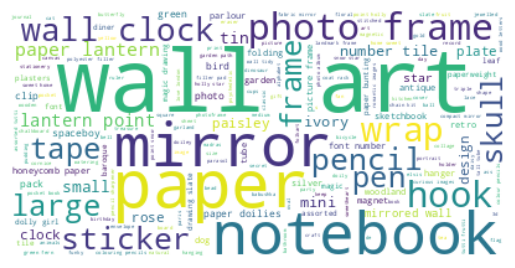

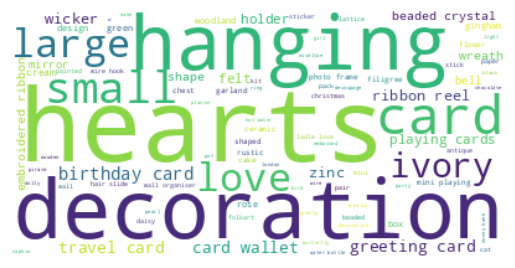

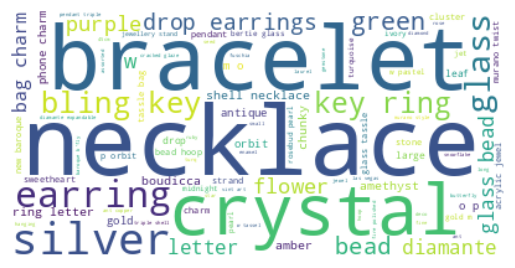

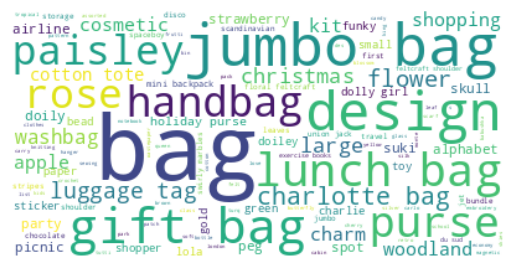

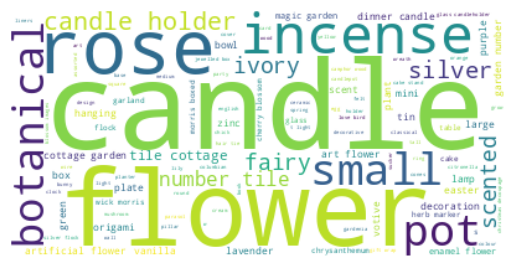

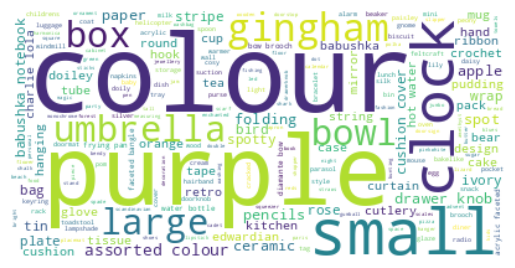

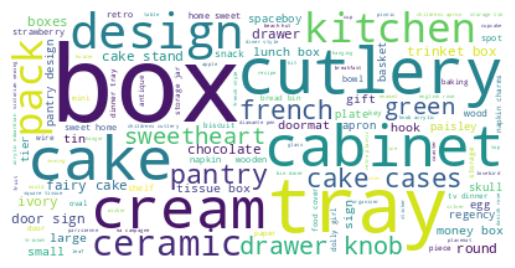

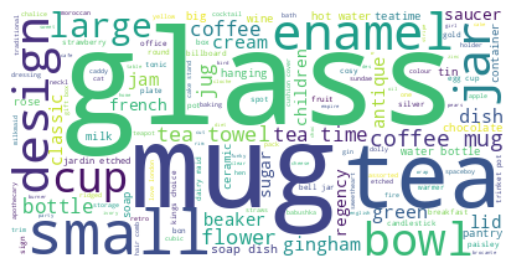

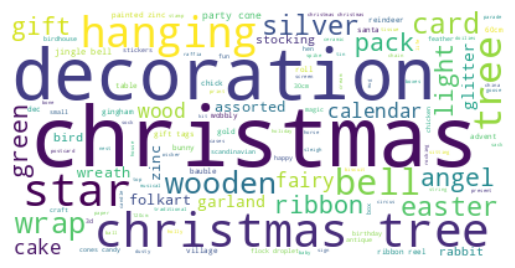

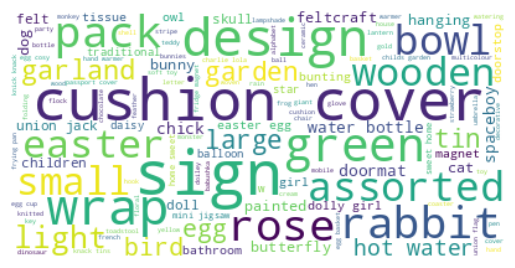

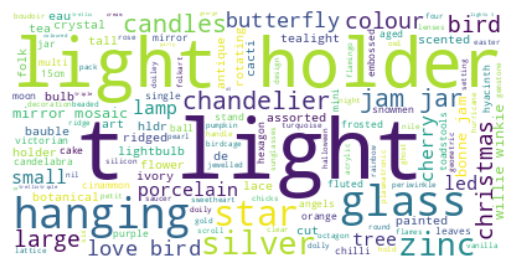

In [ ]:
word_cloud(res,0)
word_cloud(res,1)
word_cloud(res,2)
word_cloud(res,3)
word_cloud(res,4)
word_cloud(res,5)
word_cloud(res,6)
word_cloud(res,7)
word_cloud(res,8)
word_cloud(res,9)
word_cloud(res,10)

#UMAP

In [ ]:
!pip install "umap-learn ==  0.5.6"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 7.2 MB/s eta 0:00:00


In [ ]:
embed_s_nf, embed_s_nf_df = encode(df['Description'].unique())

In [ ]:
import umap

In [ ]:
digits0 = embed_s_nf
embedding = umap.UMAP(n_neighbors=15,
                      min_dist=0.009,
                      metric='correlation',
                      densmap=True).fit_transform(digits0.data)

In [ ]:
km_clustering(digits0,15)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

In [ ]:
clustering1 = KMeans(n_clusters=11)
clustering1.fit_predict(digits0)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



array([10,  7,  2, ...,  8, 10,  5], dtype=int32)

In [ ]:
fig = px.scatter(x=embedding.T[0], y=embedding.T[1],
                 text=df['Description'].unique(),
                 color=clustering1.labels_.astype(str)
                 )
fig.update_traces(textposition='top center')
fig.update_layout(height=1000)
fig.show()

In [ ]:
umap_df = pd.DataFrame({"product":df['Description'].unique(),"labels":clustering1.labels_})

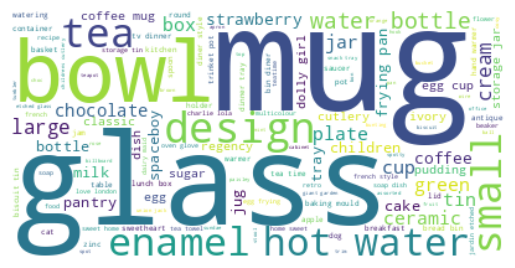

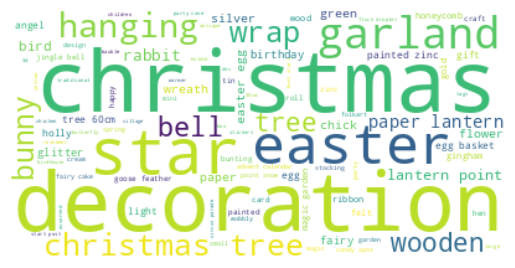

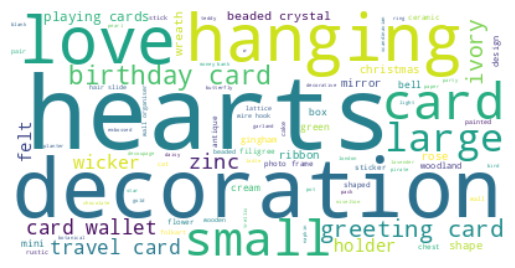

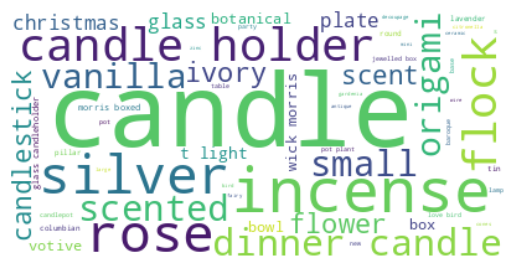

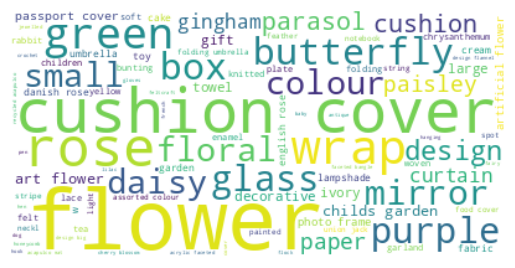

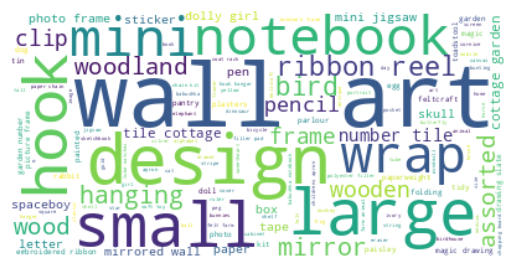

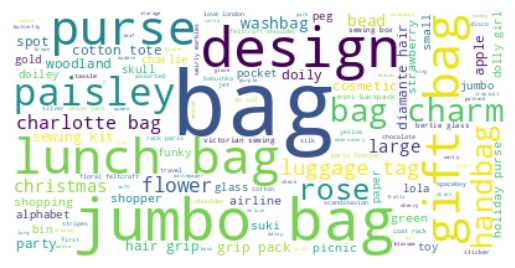

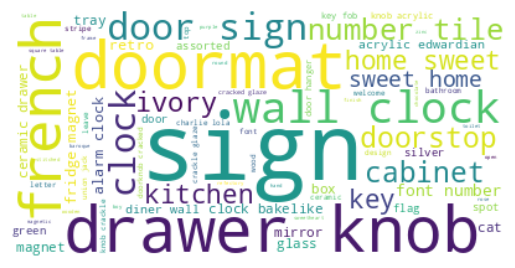

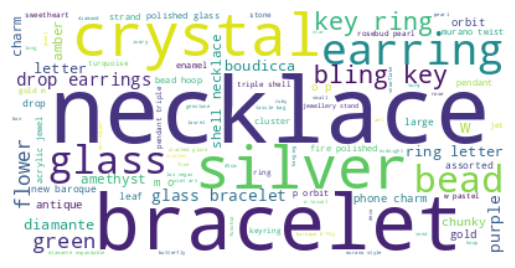

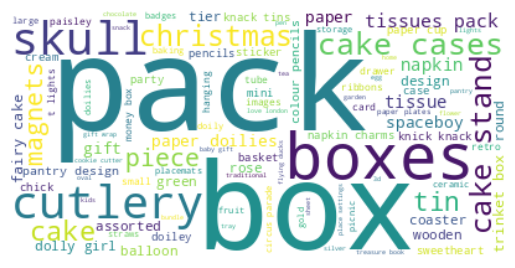

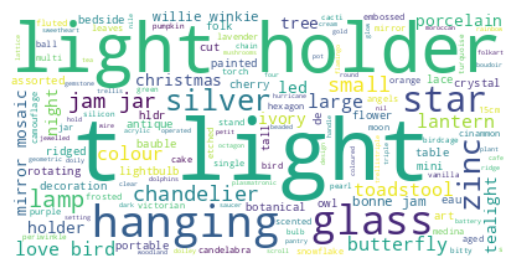

In [ ]:
word_cloud(umap_df,0)
word_cloud(umap_df,1)
word_cloud(umap_df,2)
word_cloud(umap_df,3)
word_cloud(umap_df,4)
word_cloud(umap_df,5)
word_cloud(umap_df,6)
word_cloud(umap_df,7)
word_cloud(umap_df,8)
word_cloud(umap_df,9)
word_cloud(umap_df,10)

#Result

In [ ]:
df

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

            InvoiceDate  UnitPrice  CustomerID         Country  
0        12/1/2010 8:26       2.55     17850.0  United Kingdom  
1        12/1/2010 8:26       3.39     17850.0  United Kingdom  
2        12/1/2010 8:26       2.75     17850.0  United Kingdom  
3        12/1/2010 8:26       3.39     17850.0  United Kingdom  
4        12/1/2010 8:26       3.39     17850.0  United Kingdom  
...                 ...        ...         ...             ...  
541904  12/9/2011 12:50       0.85     12680.0          France  
541905  12/9/2011 12:50       2.10     12680.0          France  
541906  12/9/2011 12:50       4.15     12680.0          France  
541907  12/9/2011 12:50       4.15     12680.0          France  
541908  12/9/2011 12:50       4.95     12680.0          France  

[406829 rows x 8 columns]

In [ ]:
cat = pd.read_csv("/content/drive/MyDrive/Project/res.csv")

In [ ]:
cat.columns = ["Description","Labels","Category"]
cat

Description  Labels  \
0      white hanging heart t-light holder       8   
1                     white metal lantern       3   
2          cream cupid hearts coat hanger       2   
3     knitted union flag hot water bottle       3   
4          red woolly hottie white heart.       2   
...                                   ...     ...   
3883            letter "w" bling key ring       1   
3884            letter "z" bling key ring       1   
3885       pink crystal skull phone charm       1   
3886   cream hanging heart t-light holder       8   
3887          paper craft , little birdie       7   

                                Category  
0                               lighting  
1     miscellaneous, general merchandise  
2             party supplies, decoration  
3     miscellaneous, general merchandise  
4             party supplies, decoration  
...                                  ...  
3883                jewelry, accessories  
3884                jewelry, accessories  
3885                jewelry, accessories  
3886                            lighting  
3887  summer supplies, easter decoration  

[3888 rows x 3 columns]

In [ ]:
df['Description'] = df.Description.astype(str)
df['Description'] = df.Description.apply(lambda x: x.lower())

In [ ]:
df_final = pd.merge(df, cat[['Description','Category']], on='Description', how='left')

In [ ]:
df_final.dropna(inplace=True)
df_final.reset_index(drop=True, inplace=True)

In [ ]:
#Cleaning
df_final['InvoiceDate'] = df_final['InvoiceDate'].apply(lambda x: x.split())

In [ ]:
df_final

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   white hanging heart t-light holder         6   
1         536365     71053                  white metal lantern         6   
2         536365    84406B       cream cupid hearts coat hanger         8   
3         536365    84029G  knitted union flag hot water bottle         6   
4         536365    84029E       red woolly hottie white heart.         6   
...          ...       ...                                  ...       ...   
404904    581587     22613          pack of 20 spaceboy napkins        12   
404905    581587     22899         children's apron dolly girl          6   
404906    581587     23254        childrens cutlery dolly girl          4   
404907    581587     23255      childrens cutlery circus parade         4   
404908    581587     22138        baking set 9 piece retrospot          3   

               InvoiceDate  UnitPrice  CustomerID         Country  \
0        [12/1/2010, 8:26]       2.55     17850.0  United Kingdom   
1        [12/1/2010, 8:26]       3.39     17850.0  United Kingdom   
2        [12/1/2010, 8:26]       2.75     17850.0  United Kingdom   
3        [12/1/2010, 8:26]       3.39     17850.0  United Kingdom   
4        [12/1/2010, 8:26]       3.39     17850.0  United Kingdom   
...                    ...        ...         ...             ...   
404904  [12/9/2011, 12:50]       0.85     12680.0          France   
404905  [12/9/2011, 12:50]       2.10     12680.0          France   
404906  [12/9/2011, 12:50]       4.15     12680.0          France   
404907  [12/9/2011, 12:50]       4.15     12680.0          France   
404908  [12/9/2011, 12:50]       4.95     12680.0          France   

                                  Category  
0                                 lighting  
1       miscellaneous, general merchandise  
2               party supplies, decoration  
3       miscellaneous, general merchandise  
4               party supplies, decoration  
...                                    ...  
404904      kitchenware, cutlery, utensils  
404905      kitchenware, cutlery, utensils  
404906      kitchenware, cutlery, utensils  
404907      kitchenware, cutlery, utensils  
404908  miscellaneous, general merchandise  

[404909 rows x 9 columns]

In [ ]:
date_l = np.array(list(df_final['InvoiceDate']))

In [ ]:
df_final['Date'] = date_l.T[0]
df_final['Time'] = date_l.T[1]

In [ ]:
df_final.drop(columns=['InvoiceDate'],inplace=True)

In [ ]:
df_final['Description'] = df_final['Description'].apply(lambda x: x.capitalize())
df_final['Category'] = df_final['Category'].apply(lambda x: x.title())

In [ ]:
df_final

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   White hanging heart t-light holder         6   
1         536365     71053                  White metal lantern         6   
2         536365    84406B       Cream cupid hearts coat hanger         8   
3         536365    84029G  Knitted union flag hot water bottle         6   
4         536365    84029E       Red woolly hottie white heart.         6   
...          ...       ...                                  ...       ...   
404904    581587     22613          Pack of 20 spaceboy napkins        12   
404905    581587     22899         Children's apron dolly girl          6   
404906    581587     23254        Childrens cutlery dolly girl          4   
404907    581587     23255      Childrens cutlery circus parade         4   
404908    581587     22138        Baking set 9 piece retrospot          3   

        UnitPrice  CustomerID         Country  \
0            2.55     17850.0  United Kingdom   
1            3.39     17850.0  United Kingdom   
2            2.75     17850.0  United Kingdom   
3            3.39     17850.0  United Kingdom   
4            3.39     17850.0  United Kingdom   
...           ...         ...             ...   
404904       0.85     12680.0          France   
404905       2.10     12680.0          France   
404906       4.15     12680.0          France   
404907       4.15     12680.0          France   
404908       4.95     12680.0          France   

                                  Category       Date   Time  
0                                 Lighting  12/1/2010   8:26  
1       Miscellaneous, General Merchandise  12/1/2010   8:26  
2               Party Supplies, Decoration  12/1/2010   8:26  
3       Miscellaneous, General Merchandise  12/1/2010   8:26  
4               Party Supplies, Decoration  12/1/2010   8:26  
...                                    ...        ...    ...  
404904      Kitchenware, Cutlery, Utensils  12/9/2011  12:50  
404905      Kitchenware, Cutlery, Utensils  12/9/2011  12:50  
404906      Kitchenware, Cutlery, Utensils  12/9/2011  12:50  
404907      Kitchenware, Cutlery, Utensils  12/9/2011  12:50  
404908  Miscellaneous, General Merchandise  12/9/2011  12:50  

[404909 rows x 10 columns]

In [ ]:
# df_final.to_csv('ecommerce_data.csv', index=False)
# !cp ecommerce_data.csv "/content/drive/MyDrive/Project"